### Importing the libs

In [1]:
!pip install MiniSom

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing the dataset

In [3]:
dataset = pd.read_csv('data/Credit_Card_Applications.csv')
dataset

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


In [4]:
X = dataset.iloc[:, :-1].values
X

array([[1.5776156e+07, 1.0000000e+00, 2.2080000e+01, ..., 2.0000000e+00,
        1.0000000e+02, 1.2130000e+03],
       [1.5739548e+07, 0.0000000e+00, 2.2670000e+01, ..., 2.0000000e+00,
        1.6000000e+02, 1.0000000e+00],
       [1.5662854e+07, 0.0000000e+00, 2.9580000e+01, ..., 2.0000000e+00,
        2.8000000e+02, 1.0000000e+00],
       ...,
       [1.5675450e+07, 0.0000000e+00, 1.8830000e+01, ..., 2.0000000e+00,
        1.0000000e+02, 1.0000000e+00],
       [1.5776494e+07, 0.0000000e+00, 2.7420000e+01, ..., 2.0000000e+00,
        1.2000000e+02, 1.2000000e+01],
       [1.5592412e+07, 1.0000000e+00, 4.1000000e+01, ..., 1.0000000e+00,
        5.6000000e+02, 1.0000000e+00]])

In [5]:
y = dataset.iloc[:, -1].values
y

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,

### Feature Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

In [8]:
# Train the SOM

In [9]:
from minisom import MiniSom

In [10]:
# x,y -> dimensions of map, choose is arbitrary
# it cannot be too small, because we cannot observe outliers
# input len -> number of features
# we keep the customerIDs, so input len -> 15
# x,y = 10,10 -> arbitrary
# learning rate -> speed of convergence, lower is longer but more accurate
# decay_func -> can be used to improve convergence
# random seed -> initialize the random number generator
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)

# initialize the weights to small numbers close to 0
som.random_weights_init(X)

# select one random observation point from the dataset
# compute the Euclidean distances from this point to the different neurons in the network
# Select the neuron that has the min dist to the point. This neuron is winning node
# Update the weights of the winning node to move it closer to the point
# Gaussian neighbourhood func of mean the winning node, update the weights of the winning node nieghbours to move them closer to the point
#          the neighbourhood raidus is sigma in the gaussian func
# repeat these above steps (1 iteration)
som.train_random(data = X, num_iteration = 100)

In [11]:
from pylab import bone, pcolor, colorbar, plot, show

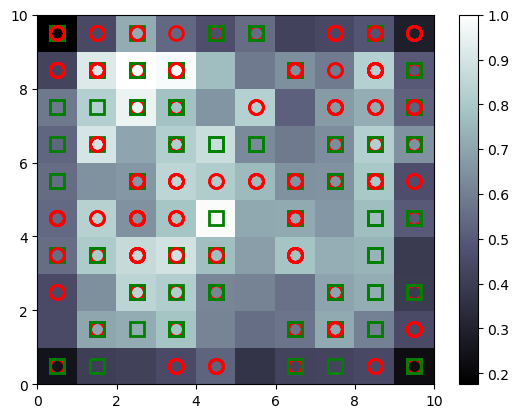

In [12]:
# MID -> mean interneuron distance
# the higher the MID the more the winning node is an outlier
# larger the MID, closer the color to black

bone()
pcolor(som.distance_map().T)
colorbar()
# black -> radius is larger, close to 1

# detect the customers those who has got an approval
# add some markers
markers = ['o', 's']
colors = ['r', 'g']
# loop over all customers, get winning node
# red circle if not approved
# green square if the customer is indeed approved

# i -> index
# x -> row vectors
# we color only the edge not inside the circle/square that is why -> markeredgecolor
# if approved y=1
# if not approved y=0
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()
# we observe both cases in some squares
# we'll separate and catch them

### Finding the frauds

In [14]:
# save as dictionary, indexes are like (0,0) (5,6). These indexes show the start point of the square
# (0,0) takes the first square that goes from x -> 0,1 and y -> 0,1. It's a 1x1 square
# These squares contain customers
# We observe 100 square, each one of them contain different number of customers with their attributes
mappings = som.win_map(X)

#fraud potentials are -> (3,8) , (2,8) these are totally white
# we're adding one list on top of another therefore axis = 0, adding vertically not horizontally
# values are still scaled, we inverse it and take out the IDs
frauds = np.concatenate((mappings[(3,8)], mappings[(2,8)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [15]:
# Fraud clients:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15571415
15699340
15644400
15684440
15699238
15577771
15599272


# Create dependent variable

In [16]:
customers = dataset.iloc[:, 1:].values
customers

array([[1.000e+00, 2.208e+01, 1.146e+01, ..., 1.000e+02, 1.213e+03,
        0.000e+00],
       [0.000e+00, 2.267e+01, 7.000e+00, ..., 1.600e+02, 1.000e+00,
        0.000e+00],
       [0.000e+00, 2.958e+01, 1.750e+00, ..., 2.800e+02, 1.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 1.883e+01, 9.540e+00, ..., 1.000e+02, 1.000e+00,
        1.000e+00],
       [0.000e+00, 2.742e+01, 1.450e+01, ..., 1.200e+02, 1.200e+01,
        1.000e+00],
       [1.000e+00, 4.100e+01, 4.000e-02, ..., 5.600e+02, 1.000e+00,
        1.000e+00]])

In [17]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

### Feature scaling

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
sc = StandardScaler()
customers = sc.fit_transform(customers)

### Build the ANN

In [20]:
import tensorflow as tf

In [21]:
# Init the ANN
ann = tf.keras.models.Sequential()

In [22]:
# Add the input layer
ann.add(tf.keras.layers.Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))

In [23]:
# Add the output layer
ann.add(tf.keras.layers.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

### Train the ANN

In [24]:
# Compile
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
# Train the ANN on the training set
ann.fit(customers, is_fraud, batch_size = 1, epochs = 2)

Epoch 1/2
  1/690 [..............................] - ETA: 1:39 - loss: 0.6931 - accuracy: 1.0000

2024-04-04 11:03:41.743789: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


690/690 [==============================] - 0s 309us/step - loss: 0.4334 - accuracy: 0.9884
Epoch 2/2
690/690 [==============================] - 0s 295us/step - loss: 0.1082 - accuracy: 0.9899


### Predicting

In [26]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

22/22 [==============================] - 0s 319us/step


In [27]:
# Probability of fraud 
y_pred

array([[1.57997850e+07, 7.02238991e-04],
       [1.56214230e+07, 1.18025346e-03],
       [1.56548590e+07, 2.74334918e-03],
       ...,
       [1.56471910e+07, 1.45122945e-01],
       [1.56739070e+07, 1.46558389e-01],
       [1.56992380e+07, 1.58279151e-01]])